# Co:Create Tokenomics Simulation Exercise
#### Date: Oct 8th, 2022
#### Author: Michelle Wang

# Key Assumptions

### General
1. All tokens are priced in USD
2. No secondary market speculative activities exist, we are always able to exchange CO and native Create protocol tokens on a DEX with FMV (no spread, no transaction fee) —> token prices only change when activities affecting either the supply or the total market cap of a token happen

### Regarding Create Protocol
1. An inflationary factor is introduced to each create protocol at the same rate by accumulating block rewards to their DAO treasury daily at 0.1% rate
2. A deflationary factor is added through the voting process when proposals are not passed, staked tokens are burned, hence reducing the token supply
3. The value and supply of NFTs each Create projects hold are not tracked, instead, we simply assume there is always available NFT to resell
4. The amount of native tokens held by creators and collectors are not tracked, instead, we assume they will always have enough tokens to stake in order to make a proposal
5. Initial royalty split is the same with future royalty split of resale/mint/purchase
6. A percentage of the native token held in DAO treasury are swapped with Co:Create treasury for equal value of CO only at project initiation


### Regarding Co:Create Protocol
1. On a day, there is a p=10% probability that a Create Protocol will be added
2. There is a fixed supply of CO tokens until all are swapped with underlying project tokens [then we mint just enough CO for swapping with new projects so that the price of CO is not affected; this part is not developed yet]
3. CO token prices are recalculated on a daily basis by looking at the updated composition of its DAO treasury 

# Simulation Design

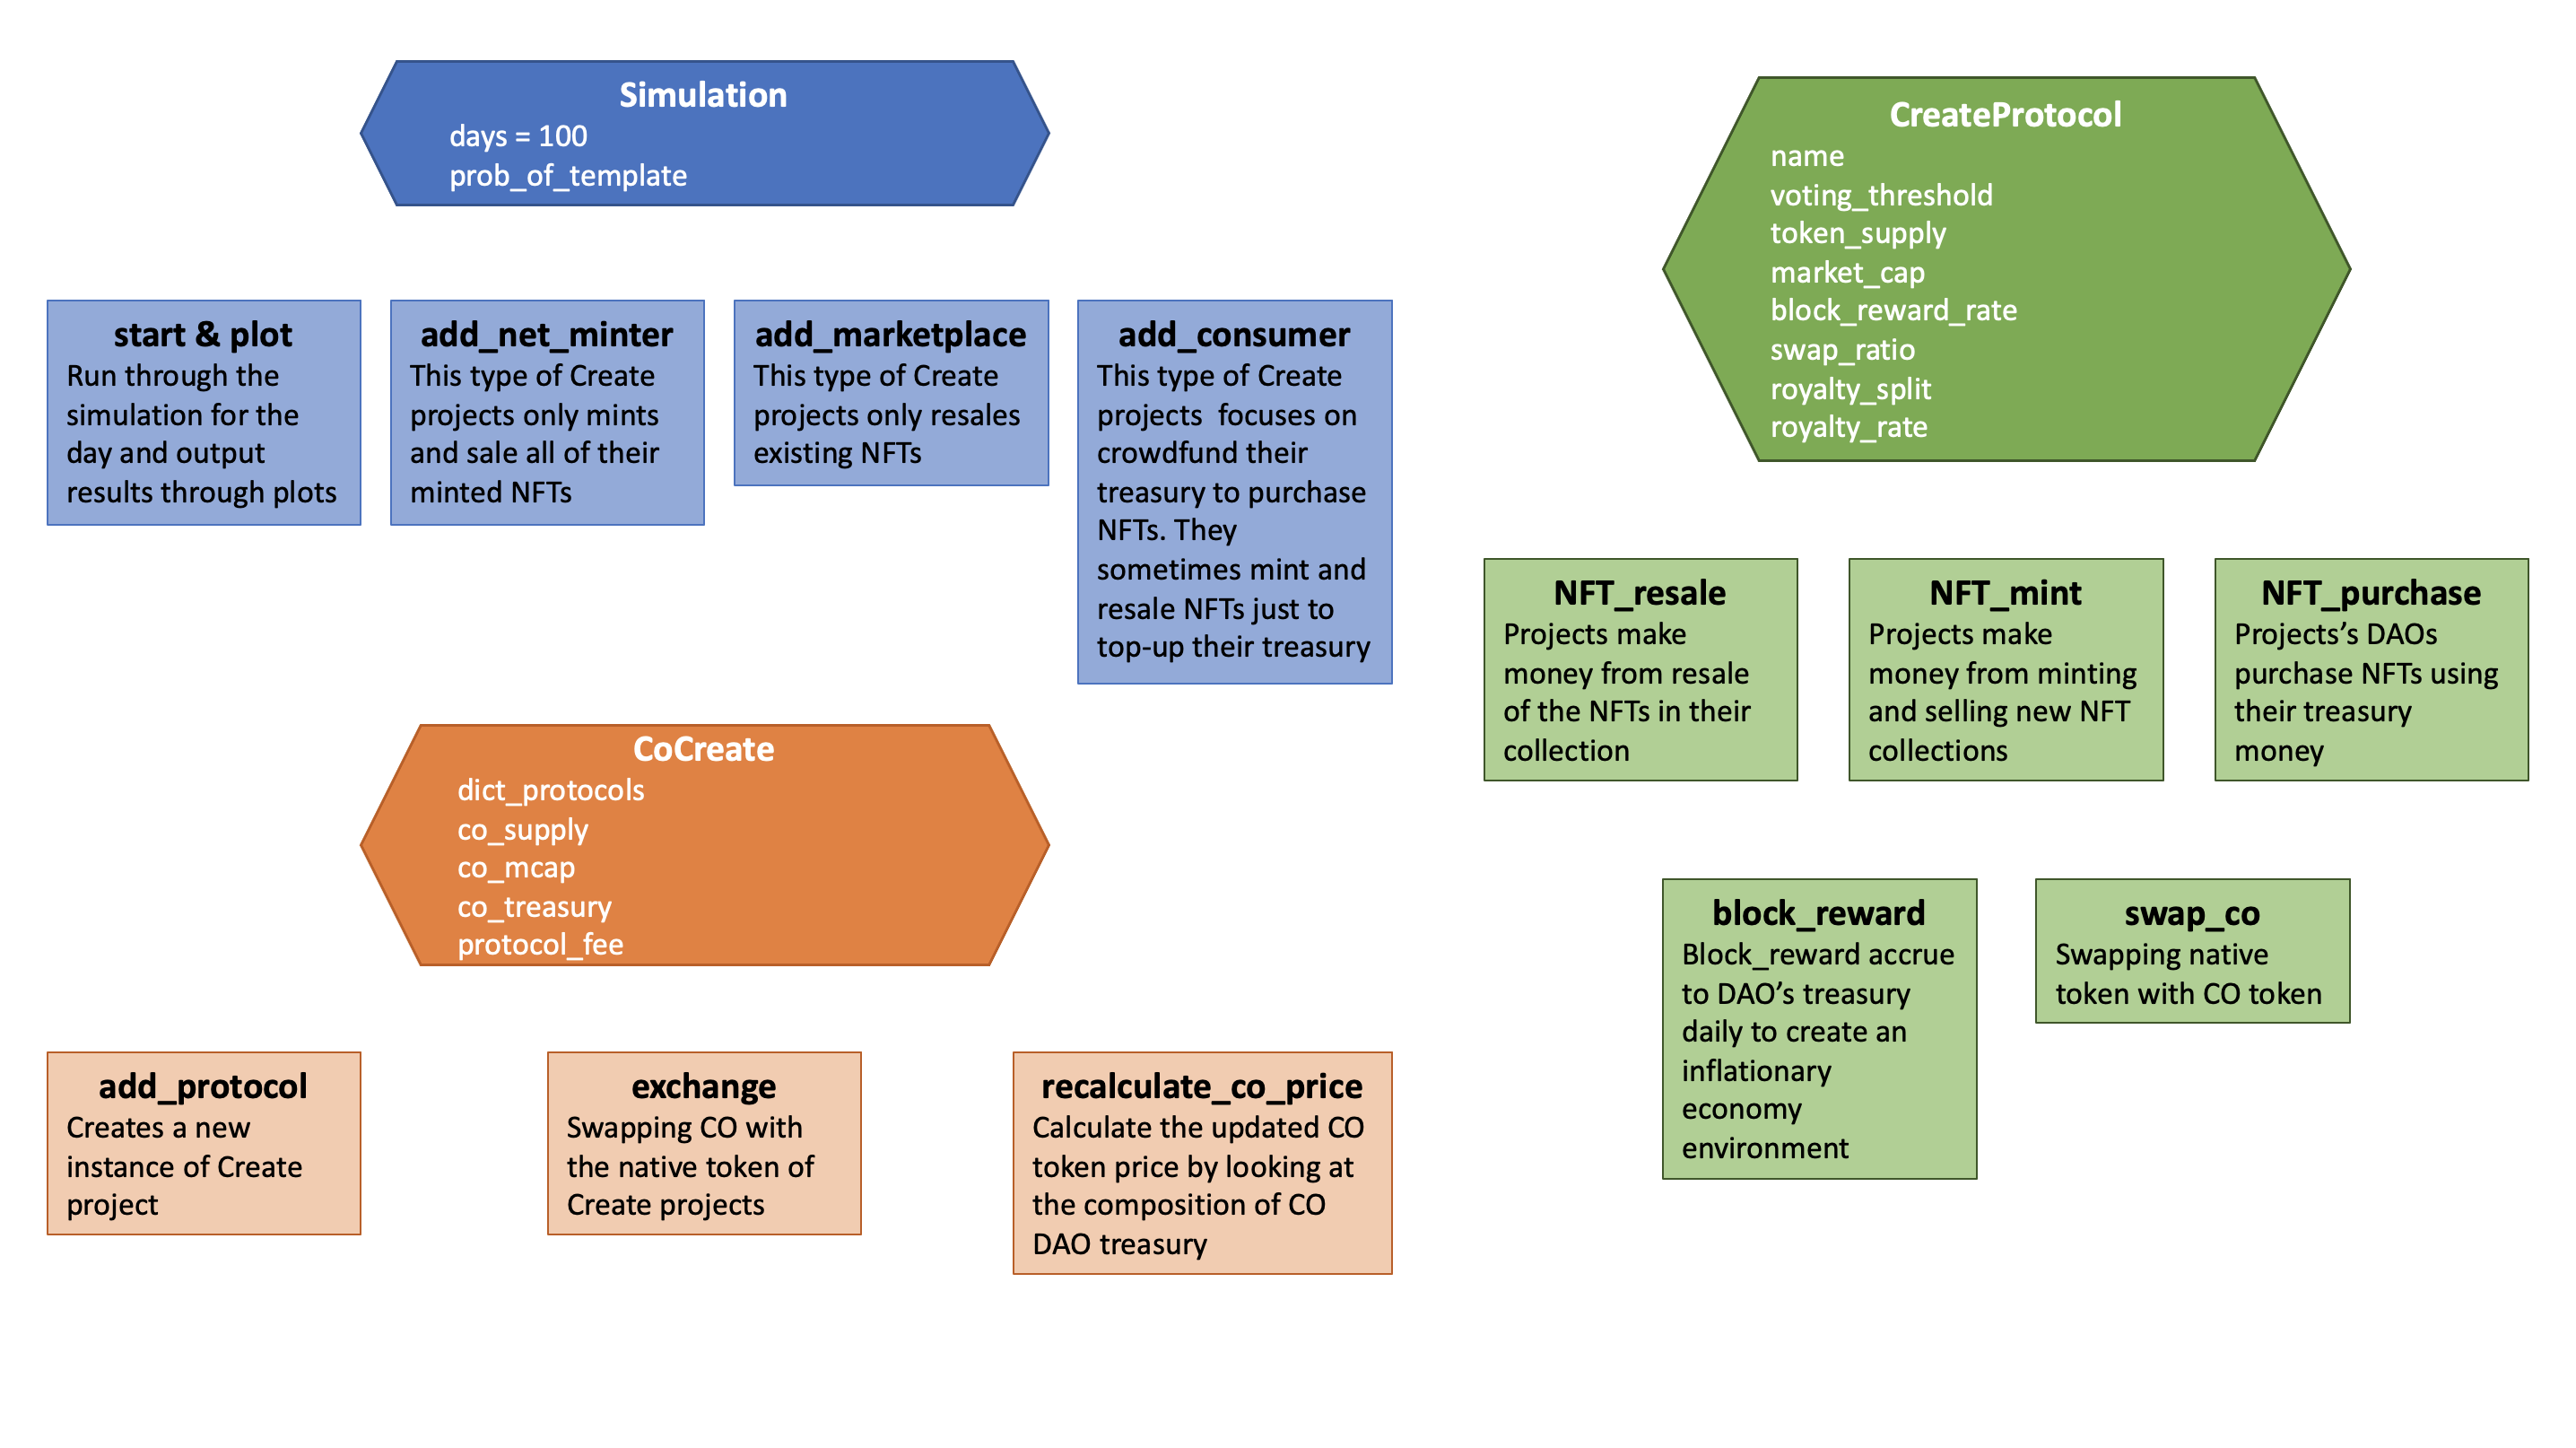

# Key Insights


### 1. CO token price vs. native token prices of each Create instance
   (1) Through the swapping mechanism, CO token benefit from the price appreciation of underlying protocols. Specifically, price appreciation is more likely for net_minter and consumer projects while native token prices may decrease for marketplace projects --> Co:Create should set a higher swap_rate with projects that are set-up to be revenue generating   
   
   (2) The key assumptions to simplify the simulation made the tokenomics somewhat optimistic. By introducing no random factor from secondary market, overlooking the behaviors of NFT creators and collectors, and the valuation fluctuation of NFT collections, the token prices of many protocol projects will "go to the moon" --> more factors and players need to be introduced to the simulation to make it more realistic

### 2. Create protocol native token supply trend   
   (1) Net_minter and consumer projects have a deflationary economy (token supply reduces over time) since proposing mint and/or purchase action burns staked native token when the votes are not passed.   
   
   (2) Marketplace projects have an inflationary economy since they have no action that burns token and the scheduled block rewards creates additional supply of tokens daily
   
   (3) More thoughts should be given to the inflationary vs deflationary nature of every Create economy according to its use case
   
### 3. Distribution of CO token
   (1) By looking at the distribution of CO tokens and the composition of Co:Create treasury, we note that consumer projects have a greater percentage due to them having the largest treasury (100% royalty split to treasury) --> Under this design, projects that are "treasury heavy" or more "centralized" will have a larger governance stake in Co:Create
   
   (2) Marketplace projects are distributed the least amount of CO token since most of their tokens are split to the hands of creators, collectors --> This is actually also what we want, Co:Create also should not keep a large portion of their token since they are deflationary
   
   (3) A natural log function was utilized to determine the dynamic protocol fee when swapping CO with project tokens. Where earlier projects will get a premium to swap with CO and later projects pay a fee. However, its effect is not too apparent in my simulation results as the different was too small (trumped by difference in projects size) --> Further analysis can be done to look at this change and optimize the function used
    

# Future Considerations

*Note: First of all, all of my major assumptions above can be turned into future considerations to adjust and redefine =)

### General Assumption
1. token_supply and market_cap are generated using uniform distribution, it could be substituted with gaussian distribution to mimic real-life scenarios
2. Can add random factors into CO prices and all native protocol tokens

### Regarding Create Protocol
1. The simulation assigns probability of events happening to imitate voting/governance procedure which can be refined by creating objects like creators, collectors…etc and model their behaviors separately
2. Generate classes for NFT collections to keep track of their market value, floor prices, daily volume and etc.
3. Design more specific mechanism for deflation/inflation tokenomics based on the purpose and target audience of the projects

### Regarding Co:Create Protocol
1. Complete the swapping mechanism to have Co:Create create more CO when treasury runs out
2. Design a rewarding/discount mechanism for superstar future Create projects to swap more native tokens with Co:Create
3. For Create token that increase in supply, more tokens should be swapped besides the initial swap




# ==============================================================

In [345]:
import random
import math
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict, OrderedDict
from enum import Enum


In [346]:
class CreateProtocol:
    """One instance of the Base Create Protocol"""
    
    def __init__(
        self,
        name, 
        voting_threshold,
        token_supply,
        market_cap,
        block_reward_rate,
        swap_ratio,
        royalty_split_dao,
        royalty_rate=0.1,
    ):
        self.name = name
        self.voting_threshold = voting_threshold
        self.royalty_rate_resale = royalty_rate
        self.royalty_split_dao = royalty_split_dao
        self.token_supply = token_supply
        self.market_cap = market_cap # in usd, based on private valuation
        self.block_reward_rate = block_reward_rate
        self.swap_ratio = swap_ratio
        self.dao_treasury_native = self.token_supply * self.royalty_split_dao
        self.dao_treasury_co = 0
    
    def get_token_price(self):
        return self.market_cap / self.token_supply
    
    def get_token_supply(self):
        return self.token_supply
    
    def get_co_distribution(self):
        return self.dao_treasury_co
    
    def NFT_resale(self, sale_proceeds):
        self.dao_treasury_native += sale_proceeds * self.royalty_rate_resale * self.royalty_split_dao / self.get_token_price()
        self.market_cap += sale_proceeds * self.royalty_rate_resale * self.royalty_split_dao #do we care about nft collector&creator here?
    
    def NFT_mint(self, total_proceeds, proposer_fee_pct, staked_token, vote_pass): # assume always sold out
        if vote_pass > self.voting_threshold:
            proposer_fee = self.token_supply * self.block_reward_rate * proposer_fee_pct
            self.dao_treasury_native += total_proceeds * self.royalty_split_dao / self.get_token_price() - proposer_fee
            self.market_cap += total_proceeds
        else: # burn
            self.token_supply *= (1-staked_token)
        

    def NFT_purchase(self, total_spend, staked_token, vote_pass):
        if (
            vote_pass > self.voting_threshold 
            and self.dao_treasury_native > total_spend/self.get_token_price()
        ):
            self.dao_treasury_native -= total_spend/self.get_token_price()
            self.market_cap -= total_spend
        else: # burn
            self.dao_treasury_native -= staked_token*self.token_supply
            self.token_supply *= (1-staked_token)
            
    def block_reward(self):
        self.dao_treasury_native += self.token_supply*self.block_reward_rate
        self.token_supply *= 1+self.block_reward_rate
            
    def swap_co(self, co_price, protocol_fee):
        swap_co_count = self.dao_treasury_native * self.swap_ratio * self.get_token_price() / co_price
        self.dao_treasury_co += swap_co_count * (1-protocol_fee)
        
        swap_native_count = self.dao_treasury_native * self.swap_ratio
        self.dao_treasury_native -= swap_native_count
        
        return swap_co_count, swap_native_count
    

In [462]:
class CoCreateProtocol:
    """Class that represents the Co:Create ecosystem"""
    
    def __init__(self, co_supply, market_cap):
        self.create_protocols = OrderedDict()
        self.co_supply = co_supply
        self.co_mcap = market_cap
        self.co_treasury = defaultdict(int)
        self.co_treasury["CO"] = co_supply
        self.protocol_fee_threshold = 10 # fixed, project number before protocol fee becomes positive
    
    def add_protocol(self, create_protocol):
        """Add a single createProtocols into the Co:Create ecosystem"""
        self.create_protocols[create_protocol.name] = create_protocol
        self.exchange(create_protocol)
    
    def exchange(self, create_protocol):
        co_count, native_count = self.create_protocols[create_protocol.name].swap_co(self.get_co_price(), self._get_protocol_fee())
        self.co_treasury["CO"] -= co_count*(1-self._get_protocol_fee())
        self.co_treasury[create_protocol.name] += native_count
    
    def get_co_price(self):
        return self.co_mcap / self.co_supply

    def recalculate_co_price(self):
        self.co_mcap = self.co_treasury["CO"] * self.get_co_price()
        
        for name, protocol in self.get_create_protocols_iter():
            self.co_mcap += protocol.get_token_price() * self.co_treasury[name] 

        return self.co_mcap / self.co_supply
    
    def get_create_protocols(self):
        return self.create_protocols
    
    def get_create_protocols_iter(self):
        return self.create_protocols.items()
    
    def get_co_treasury(self):
        return self.co_treasury
    
    def _get_protocol_fee(self):
        return math.log(len(self.create_protocols)/self.protocol_fee_threshold) / 100
    

In [484]:
class ProtocolTemplate(Enum):
    NET_MINTER = 1
    MARKETPLACE = 2
    CONSUMER = 3

class Simulation:
    def __init__(self, days, net_minter_prob, marketplace_prob, consumer_prob):
        self.days = days
        self.co_create = CoCreateProtocol(30000000, 30000000) # assume 30M tokens at $30M valuation
        self.template_protocol_mapping = {}
        self.template_probability = [net_minter_prob, marketplace_prob, consumer_prob]
        
    def start(self):
#         print ("====Action Log====")
        self.results = {
            "price": defaultdict(list), 
            "supply": defaultdict(list), 
            "co_distribution": defaultdict(float),
            "co_treasury": defaultdict(float),
        }
        for day in range(self.days):
#             print ("Day",day)
            if random.randint(0, 100) > 90: # new create protocol?
                template = random.choices(list(ProtocolTemplate), self.template_probability)[0]
                
                protocol_id = len([type for type in self.template_protocol_mapping.values() if type == template.name]) + 1
                protocol_name = "".join(template.name + "_" + str(protocol_id))
#                 print(protocol_name,"added")
                
                if template.name == ProtocolTemplate.NET_MINTER.name:
                    self.add_net_minter(protocol_name)
                elif template.name == ProtocolTemplate.MARKETPLACE.name:
                    self.add_marketplace(protocol_name)
                elif template.name == ProtocolTemplate.CONSUMER.name:
                    self.add_consumer(protocol_name)
                
                for _ in range(day):
                    self.results["price"][protocol_name].append(0)
                    self.results["supply"][protocol_name].append(0)
                
                self.results["co_distribution"][protocol_name] = (
                    self.co_create.get_create_protocols()[protocol_name].get_co_distribution()
                )
   
            for name, protocol in self.co_create.get_create_protocols_iter():
                template = self.template_protocol_mapping[name]
                if template == ProtocolTemplate.NET_MINTER.name:
                    #mint event
                    if random.randint(1, 100) >= 0:
                        protocol.NFT_mint(
                            total_proceeds=random.randint(1000000,10000000), #$1M to $10M 
                            proposer_fee_pct=0.1, 
                            staked_token=random.randint(100,300)/10000, #1% to 3% 
                            vote_pass=random.randint(0,100)/100, #a vote result between 0 and 1
                        )
                elif template == ProtocolTemplate.MARKETPLACE.name:
                    #total resale
                    protocol.NFT_resale(sale_proceeds=random.randint(1000,100000)) #0.1% to 1% of estimated mint 
                elif template == ProtocolTemplate.CONSUMER.name:
                    #mint event
                    if random.randint(1, 100) >= 90:
                        protocol.NFT_mint(
                            total_proceeds=random.randint(1000000,10000000), #$1M to $10M 
                            proposer_fee_pct=0.1, 
                            staked_token=random.randint(100,300)/10000, #1% to 3% 
                            vote_pass=random.randint(0,100)/100, #a vote result between 0 and 1
                        )
                    #total resale
                    if random.randint(1, 100) >= 80:
                        protocol.NFT_resale(sale_proceeds=random.randint(1000,100000)) #0.1% to 1% of estimated mint 
                    #purchase event
                    if random.randint(1, 100) >= 70:
                        protocol.NFT_purchase(
                            total_spend=random.randint(10000,1000000), # 10x more than resale volume
                            staked_token=random.randint(100,300)/10000, #1% to 3% 
                            vote_pass=random.randint(0,100)/100, #a vote result between 0 and 1
                        )
                
                #distribute block rewards
                protocol.block_reward()
            
            for name, protocol in self.co_create.get_create_protocols_iter():
                self.results["price"][name].append(protocol.get_token_price())
                self.results["supply"][name].append(protocol.get_token_supply())
            self.results["price"]["CO"].append(self.co_create.recalculate_co_price())
            
        for name, balance in self.co_create.get_co_treasury().items():
            if name == "CO":
                self.results["co_treasury"][name] = self.co_create.get_co_price() * balance
                self.results["co_distribution"][name] = balance
            else:
                self.results["co_treasury"][name] = self.co_create.get_create_protocols()[name].get_token_price() * balance

        
    def plot_prices(self):
        fig = plt.figure(figsize=(12,8))
        for name, protocol in self.co_create.get_create_protocols_iter():
            df = pd.DataFrame({
                "day": np.array([i+1 for i in range(self.days)]),
                "price": self.results["price"][name],
            })
            plt.plot(df.day, df.price, label=name)
    
        df = pd.DataFrame({
            "day": np.array([i+1 for i in range(self.days)]),
            "price": self.results["price"]["CO"],
        })
        df[df.price==0]=None
        plt.plot(df.day, df.price, label="CO", linewidth=5)
        
        plt.title("Token Price Changes Over Time")
        plt.xlabel("day")
        plt.ylabel("Price ($)")
        
        plt.legend()
        
        plt.show()
        
    def plot_tokens_supply(self):
        fig = plt.figure(figsize=(12,8))
        for name, protocol in self.co_create.get_create_protocols_iter():
            df = pd.DataFrame({
                "day": np.array([i+1 for i in range(self.days)]),
                "supply": self.results["supply"][name],
            })
            plt.plot(df.day, df.supply, label=name)
    
        df[df.supply==0]=None
        
        plt.title("Tokens Supply Changes Over Time")
        plt.xlabel("day")
        plt.ylabel("token supply")
        
        plt.legend()
        
        plt.show()
        
    def plot_co_distribution(self):
        self.dict_to_pie(self.results["co_treasury"],"Composition of CO Treasury")
        self.dict_to_pie(self.results["co_distribution"],"Distribution of CO Token")
        
        
    def dict_to_pie(self,data,name):
        fig = plt.figure(figsize=(10,5))
        labels = []
        sizes = []
        for x,y in data.items():
            labels.append(x)
            sizes.append(y)
        pie = plt.pie(sizes)
        plt.title(name)
        plt.legend(pie[0],labels,bbox_to_anchor=(1.5,0.5), loc="right")
        plt.show()
    

    def add_net_minter(self, name):
        """This type of project only mints and hodl their NFTs
        They have fixed supply of their native token
        When NFTs are minted, proceeds are exchanged into native token --> hence native token price increase
        Swapping to CO is only done once at initiation"""
        self.co_create.add_protocol(
            CreateProtocol(
                name=name, 
                voting_threshold=0.75, #high threshold
                token_supply=random.randint(10000000,1000000000), # 10M to 1B
                market_cap=random.randint(1000000, 100000000), # $1M to $100M
                block_reward_rate=0.001, # annual inflation = 1.0001^365 = 3%-4%
                swap_ratio=0.1,
                royalty_split_dao=0.25,
                royalty_rate=0.1
            )
        )

        self.template_protocol_mapping[name] = ProtocolTemplate.NET_MINTER.name
        
    def add_marketplace(self, name):
        """This type of project only mints and hodl their NFTs
        They have fixed supply of their native token
        When NFTs are minted, proceeds are exchanged into native token --> hence native token price increase
        Swapping to CO is only done once at initiation"""
        self.co_create.add_protocol(
            CreateProtocol(
                name=name, 
                voting_threshold=0, #no threshold
                token_supply=random.randint(10000000,1000000000), # 10M to 1B
                market_cap=random.randint(1000000, 100000000), # $1M to $100M
                block_reward_rate=0.001, # annual inflation = 1.0001^365 = 3%-4%
                swap_ratio=0.1,
                royalty_split_dao=0.015,
                royalty_rate=0.1
            )
        )
        
        self.template_protocol_mapping[name] = ProtocolTemplate.MARKETPLACE.name
    
    def add_consumer(self, name):
        """This type of project only mints and hodl their NFTs
        They have fixed supply of their native token
        When NFTs are minted, proceeds are exchanged into native token --> hence native token price increase
        Swapping to CO is only done once at initiation"""
        self.co_create.add_protocol(
            CreateProtocol(
                name=name, 
                voting_threshold=0.5, #medium threshold
                token_supply=random.randint(10000000,1000000000), # 10M to 1B
                market_cap=random.randint(1000000, 100000000), # $1M to $100M
                block_reward_rate=0.001, # annual inflation = 1.0001^365 = 3%-4%
                swap_ratio=0.05,
                royalty_split_dao=1,
                royalty_rate = 1
            )
        )
        
        self.template_protocol_mapping[name] = ProtocolTemplate.CONSUMER.name
        

### Simulation (1) Only net minters projects

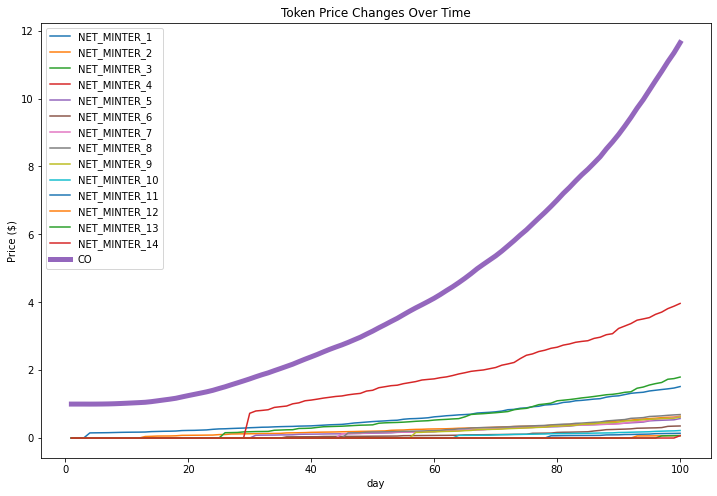

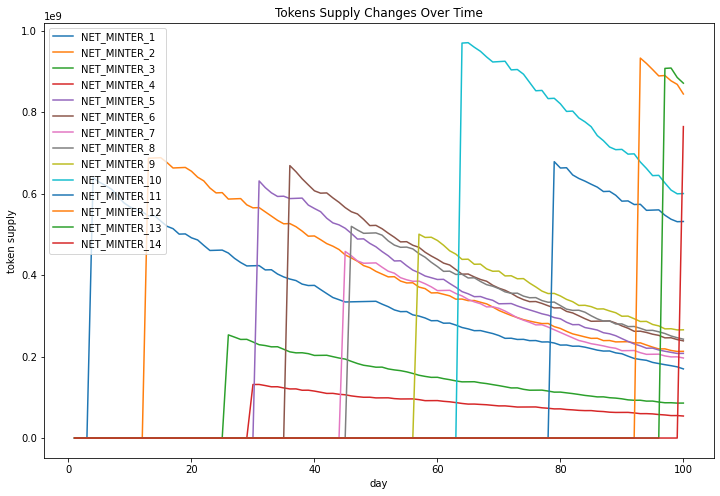

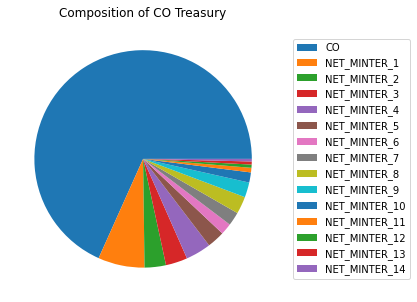

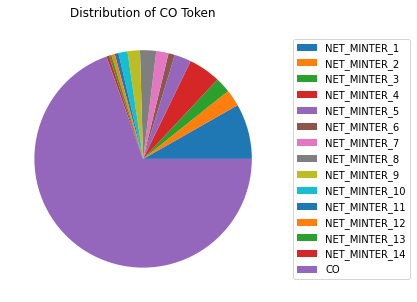

In [476]:
### Simulation (1) Only net minters projects
simulation_1 = Simulation(100, 1, 0, 0)
simulation_1.start()
simulation_1.plot_prices()
simulation_1.plot_tokens_supply()
simulation_1.plot_co_distribution()

### Simulation (2) Only marketplace projects

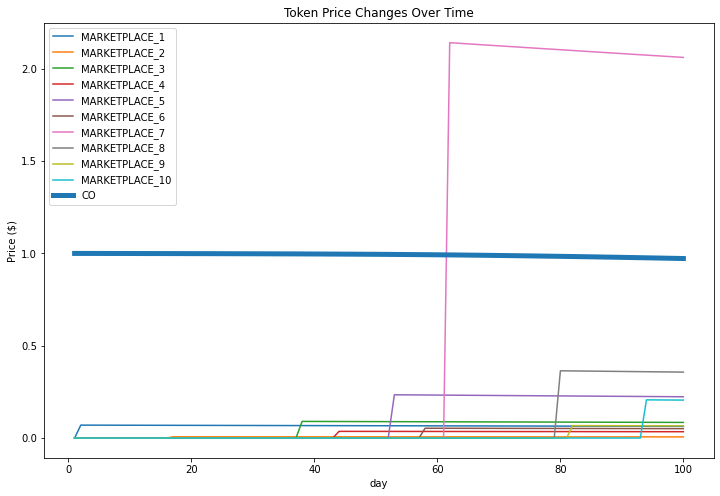

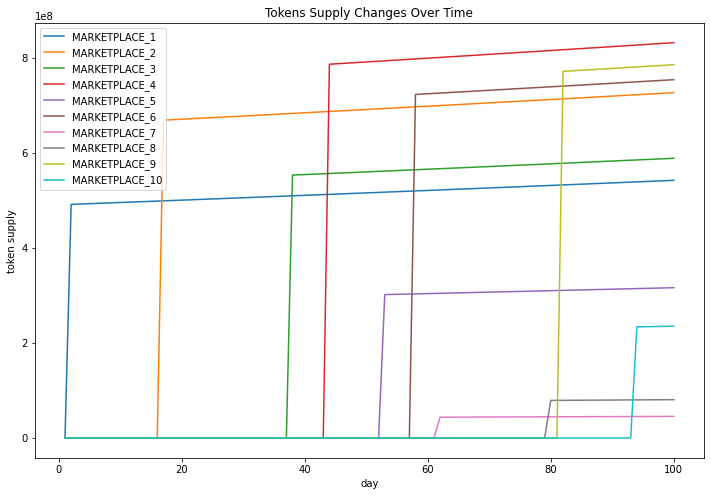

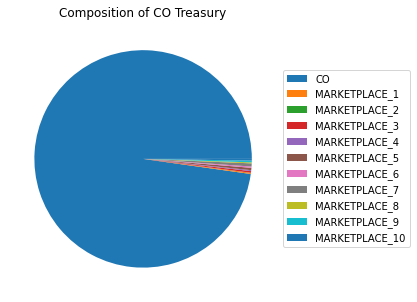

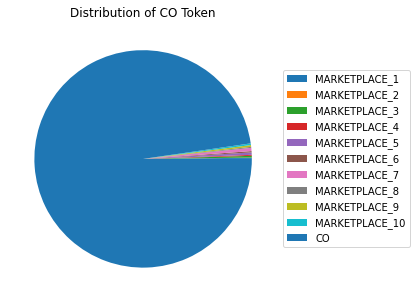

In [480]:
simulation_2 = Simulation(100, 0, 1, 0)
simulation_2.start()
simulation_2.plot_prices()
simulation_2.plot_tokens_supply()
simulation_2.plot_co_distribution()

### Simulation (3) Only consumer projects

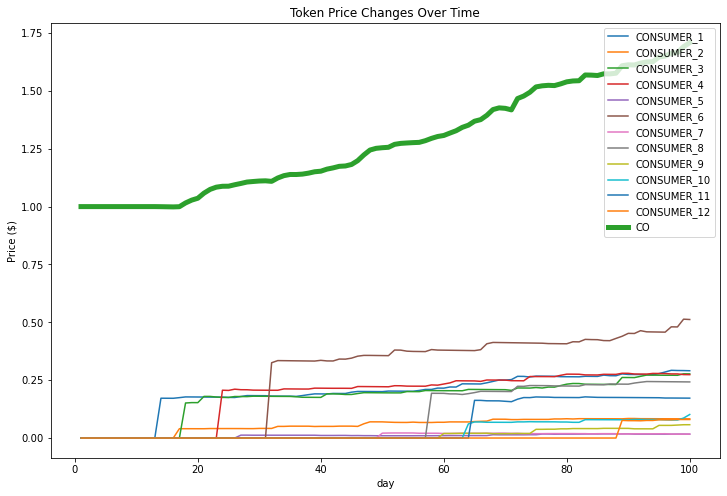

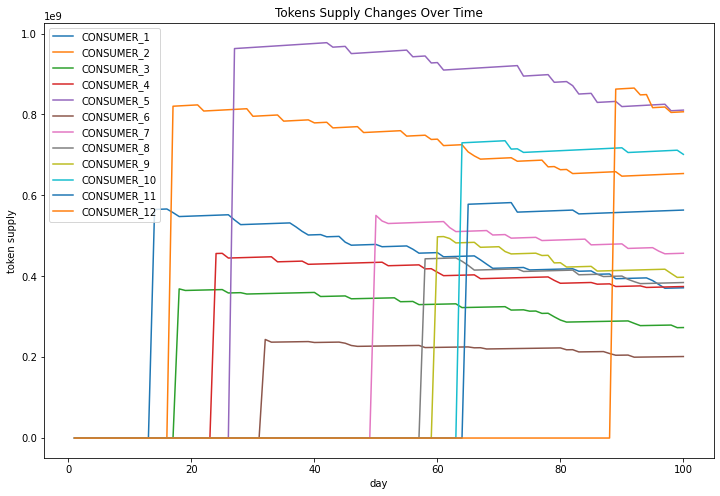

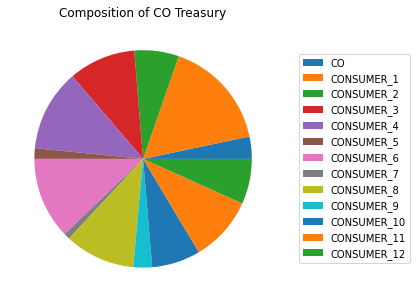

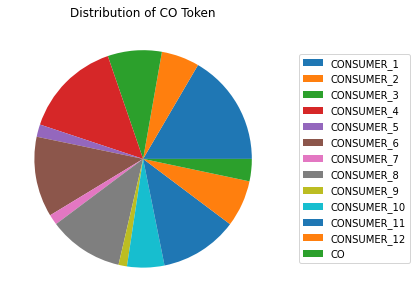

In [485]:
simulation_3 = Simulation(100, 0, 0, 1)
simulation_3.start()
simulation_3.plot_prices()
simulation_3.plot_tokens_supply()
simulation_3.plot_co_distribution()

In [486]:
### Simulation (4) All 3 templates of Create projects combined

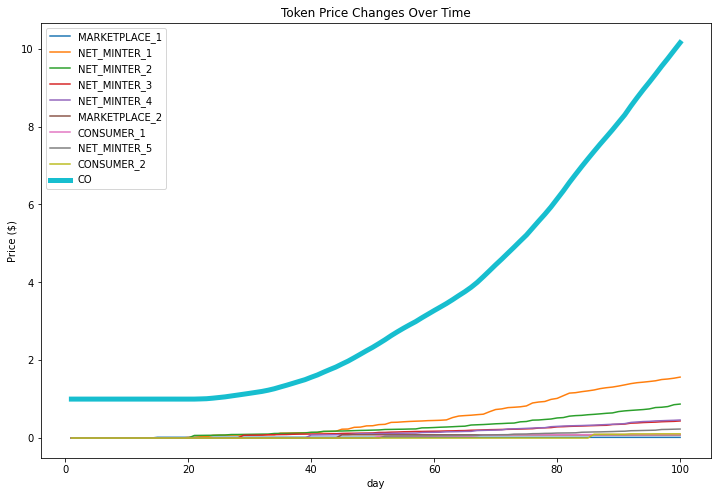

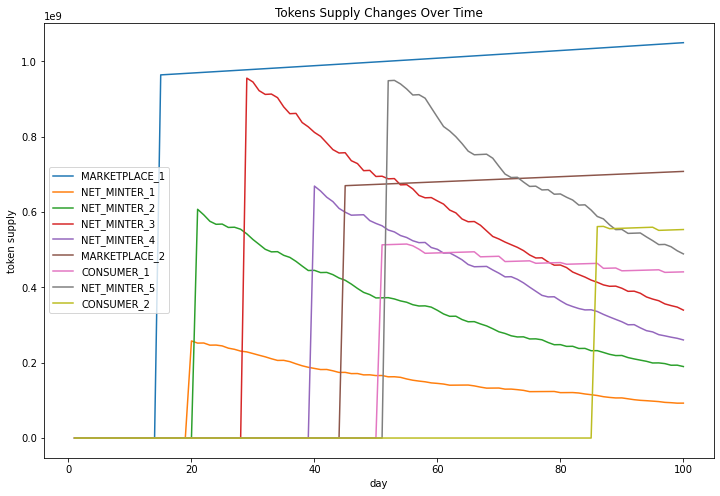

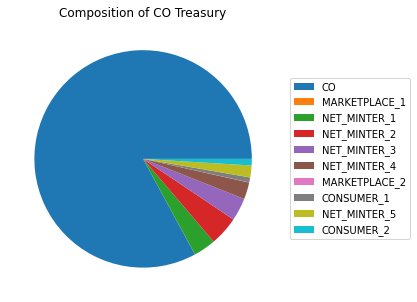

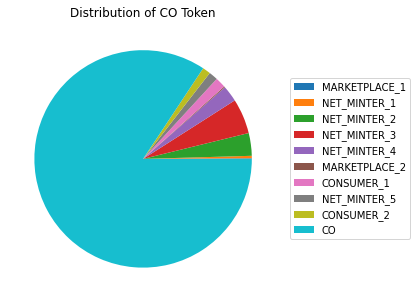

In [488]:
simulation_4 = Simulation(100, 0.3, 0.4, 0.3)
simulation_4.start()
simulation_4.plot_prices()
simulation_4.plot_tokens_supply()
simulation_4.plot_co_distribution()